# Movies Recommender System

In this notebook, I aim to implement several recommendation algorithms, including content-based filtering, popularity-based methods, and collaborative filtering. Additionally, I will combine these models into an ensemble to develop a final recommendation system. For this purpose, I will use two datasets from MovieLens:

- **Full Dataset**: Contains 26 million ratings and 750,000 tag applications for 45,000 movies, provided by 270,000 users. It also includes tag genome data with 12 million relevance scores across 1,100 tags.  
- **Small Dataset**: Includes 100,000 ratings and 1,300 tag applications for 9,000 movies, contributed by 700 users.  

The simple recommender system will be built using data from the Full Dataset, while all personalized recommendation systems will rely on the Small Dataset due to the limited computing resources available. To begin, I will first construct the simple recommender system.

In [183]:
!pip install surprise == 0.1

ERROR: Invalid requirement: '==': Expected package name at the start of dependency specifier
    ==
    ^


In [184]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
# from surprise import Reader, Dataset, SVD, evaluate

import warnings; warnings.simplefilter('ignore')

### Simple Recommender

The Simple Recommender provides generalized recommendations to all users, focusing on movie popularity and, optionally, genre. The core concept behind this model is that widely popular and critically acclaimed movies are more likely to appeal to the general audience. However, this model does not offer personalized recommendations tailored to individual users.

The implementation of the Simple Recommender is straightforward. It involves sorting the movies by their ratings and popularity and then displaying the top-ranked movies. Optionally, a genre filter can be applied to retrieve the top movies within a specific genre.

In [185]:
# Load movie metadata and preview first 5 rows
movie_data = pd.read_csv('/content/movies_metadata.csv')
movie_data.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [186]:
# Clean and extract genre names from the 'genres' column
movie_data['genres'] = movie_data['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

To create our **Top Movies Chart**, I will leverage TMDB Ratings and use IMDb's *weighted rating* formula to rank the movies. This formula ensures that both the average rating and the number of votes contribute to the ranking. The formula is given as:

$$
\text{Weighted Rating (WR)} = \left( \frac{v}{v + m} \cdot R \right) + \left( \frac{m}{v + m} \cdot C \right)
$$

Where:
- **v**: Number of votes for the movie.  
- **m**: Minimum number of votes required to be listed in the chart.  
- **R**: Average rating of the movie.  
- **C**: Mean vote across all movies in the dataset.

### Determining the Minimum Vote Threshold (*m*)
To decide on the value of *m*, I will use the **95th percentile** as the cutoff. This means that a movie must have more votes than at least 95% of the movies in the dataset to qualify for the chart.

### Building the Charts
With the threshold established, I will proceed to:
1. Construct the overall **Top 250 Chart** using the weighted rating formula.
2. Define a function that allows building charts for movies in a specific genre.

Let’s start by determining *m* and constructing the charts!

In [187]:
# Filter valid vote counts and averages, calculate mean vote average
vote_counts = movie_data[movie_data['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = movie_data[movie_data['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
C

5.244896612406511

In [188]:
# Calculate the 95th percentile of vote counts
m = vote_counts.quantile(0.95)
m

434.0

In [189]:
# Extract year from 'release_date' and handle missing values
movie_data['year'] = pd.to_datetime(movie_data['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [190]:
# Filter movies with vote counts above threshold and valid vote averages
qualified = movie_data[(movie_data['vote_count'] >= m) & (movie_data['vote_count'].notnull()) & (movie_data['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(2274, 6)

Based on the data analysis:

- A movie must have at least **434 votes** on TMDB to qualify for the chart, representing the **95th percentile** cutoff.  
- The average rating for a movie on TMDB is **5.244** (on a scale of 10).  
- A total of **2,274 movies** meet the criteria to be included in the chart.  

With this information, we can now proceed to build the **Top 250 Chart** using the weighted rating formula, ensuring only the top-rated and most popular movies are highlighted.

In [191]:
# Calculate weighted rating based on vote count and average
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [192]:
# Apply weighted rating formula to calculate scores for qualified movies
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

In [193]:
# Sort movies by weighted rating and select top 250
qualified = qualified.sort_values('wr', ascending=False).head(250)

### Top Movies

In [194]:
# Display top 15 movies based on weighted rating
qualified.head(15)

,title,year,vote_count,vote_average,popularity,genres,wr
15480,Inception,2010,14075,8,29.108149,"[Action, Thriller, Science Fiction, Mystery, A...",7.917588
12481,The Dark Knight,2008,12269,8,123.167259,"[Drama, Action, Crime, Thriller]",7.905871
22879,Interstellar,2014,11187,8,32.213481,"[Adventure, Drama, Science Fiction]",7.897107
2843,Fight Club,1999,9678,8,63.869599,[Drama],7.881753
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,"[Adventure, Fantasy, Action]",7.871787
292,Pulp Fiction,1994,8670,8,140.950236,"[Thriller, Crime]",7.868660
314,The Shawshank Redemption,1994,8358,8,51.645403,"[Drama, Crime]",7.864000
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.324358,"[Adventure, Fantasy, Action]",7.861927
351,Forrest Gump,1994,8147,8,48.307194,"[Comedy, Drama, Romance]",7.860656
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.423537,"[Adventure, Fantasy, Action]",7.851924


The analysis reveals that three Christopher Nolan films—**Inception**, **The Dark Knight**, and **Interstellar**—dominate the top of the chart. This result highlights a noticeable preference among TMDB users for specific genres and directors.  

### Genre-Specific Chart  
To build charts tailored to specific genres, we will adjust our criteria:  
- Relax the minimum vote requirement to the **85th percentile**, making it less restrictive compared to the **95th percentile** used for the overall chart.  

This approach ensures that a broader range of movies qualifies for genre-specific charts, allowing for more diversity while maintaining quality. Let’s define a function that implements this logic!

In [195]:
# Expand genres into separate rows and merge with original data
s = movie_data.apply(lambda x: pd.Series(x['genres']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_md = movie_data.drop('genres', axis=1).join(s)

In [196]:
# Build a chart of top movies for a given genre based on weighted rating
def build_chart(genre, percentile=0.85):
    df = gen_md[gen_md['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)

    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')

    qualified['wr'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)

    return qualified

To demonstrate our genre-specific chart methodology, let's apply it to the **Romance** genre, which was underrepresented in the generic Top Chart despite being one of the most beloved genres globally. By relaxing the minimum vote requirement to the **85th percentile**, we aim to highlight top-rated Romance movies.

### Steps to Display the Top 15 Romance Movies:
1. **Filter** the dataset for movies tagged under the "Romance" genre.  
2. **Apply the 85th percentile threshold** for the number of votes to determine the qualifying movies.  
3. **Calculate the Weighted Rating (WR)** for each qualifying movie using IMDb’s formula.  
4. **Sort** the Romance movies by their WR in descending order.  
5. **Display the Top 15** Romance movies.

Let’s execute this method to uncover the gems of the Romance genre!

In [197]:
# Get top 15 Romance movies based on weighted rating
build_chart('Romance').head(15)

,title,year,vote_count,vote_average,popularity,wr
10309,Dilwale Dulhania Le Jayenge,1995,661,9,34.457024,8.565285
351,Forrest Gump,1994,8147,8,48.307194,7.971357
876,Vertigo,1958,1162,8,18.20822,7.811667
40251,Your Name.,2016,1030,8,34.461252,7.789489
883,Some Like It Hot,1959,835,8,11.845107,7.745154
1132,Cinema Paradiso,1988,834,8,14.177005,7.744878
19901,Paperman,2012,734,8,7.198633,7.713951
37863,Sing Street,2016,669,8,10.672862,7.689483
882,The Apartment,1960,498,8,11.994281,7.599317
38718,The Handmaiden,2016,453,8,16.727405,7.566166


According to our metrics, the top romance movie is Bollywood's iconic **Dilwale Dulhania Le Jayenge (DDLJ)**. Starring Shahrukh Khan, this timeless classic is not only a standout in our genre-specific chart but also a personal favorite. Its enduring popularity and heartwarming story perfectly embody why Romance remains such a beloved genre.  

DDLJ’s well-deserved place at the top showcases the universal appeal of its themes, the charisma of its performances, and its impact on global cinema. A true masterpiece!

### Content-Based Recommender

The recommendation system we developed earlier has significant limitations, primarily its inability to personalize recommendations based on individual user preferences. It offers the same suggestions to everyone, which fails to account for unique tastes. For instance, if a user loves romantic movies like *Dilwale Dulhania Le Jayenge*, *My Name is Khan*, and *Kabhi Khushi Kabhi Gham*, they likely have a preference for Shahrukh Khan's performances and Karan Johar's direction. However, even the genre-specific charts may not highlight such nuanced preferences.

To address this, I will build a **Content-Based Filtering** system that tailors recommendations to the user's specific likes by computing the similarity between movies. This approach leverages the metadata or "content" of movies to suggest those most similar to a movie the user has enjoyed.

#### Key Components of Content-Based Filtering:
1. **Movie Overviews and Taglines**  
   Using textual data like the movie's synopsis or tagline to compute similarity.  

2. **Movie Cast, Crew, Keywords, and Genre**  
   Leveraging structured metadata (actors, directors, keywords, and genres) to identify similar movies.  

#### Approach and Considerations:
- Due to limited computational resources, I will use a subset of the available movie dataset.  
- For similarity computations, I will likely use techniques such as:
  - **TF-IDF (Term Frequency-Inverse Document Frequency)** for textual features like overviews and taglines.
  - **Cosine Similarity** or **Dot Product** to measure similarity between movies.  

This personalized engine will address the shortcomings of earlier models, offering users recommendations that align closely with their tastes. Let’s begin by constructing the two content-based recommenders!

In [198]:
# Load and filter valid TMDB IDs from links_small dataset
links_small = pd.read_csv('/content/links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

In [199]:
# Drop rows with specific indices from the movie metadata
movie_data = movie_data.drop([19730, 29503, 35587])

In [200]:
# Convert 'id' column to integer type
movie_data['id'] = movie_data['id'].astype('int')

In [201]:
# Filter movies with IDs present in links_small
smd = movie_data[movie_data['id'].isin(links_small)]
smd.shape

(9099, 25)

Our small movies metadata dataset contains **9,099 movies**, which is approximately five times smaller than the original dataset of **45,000 movies**. This reduced dataset will serve as the foundation for building our content-based recommender system.  

By working with this subset, we can manage computational limitations more effectively while still ensuring the recommendations remain meaningful and diverse. Let’s proceed to implement the two content-based filtering models!

### Movie Description Based Recommender

For the **Movie Description Based Recommender**, we will focus on using movie descriptions (synopsis) and taglines as the key features for similarity-based recommendations. Since we lack a direct quantitative metric for performance in this context, we will evaluate the model's effectiveness qualitatively, based on how well the recommendations match a user's preferences.

In [202]:
# Combine overview and tagline into a single description column
smd['tagline'] = smd['tagline'].fillna('')
smd['description'] = smd['overview'] + smd['tagline']
smd['description'] = smd['description'].fillna('')

In [203]:
# Initialize TF-IDF Vectorizer to analyze word and bi-gram frequencies
tfidf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=1, stop_words='english')

# Transform movie descriptions into TF-IDF feature matrix
tfidf_feature_matrix = tfidf_vectorizer.fit_transform(smd['description'])

In [204]:
# Check the shape of the TF-IDF feature matrix
tfidf_feature_matrix.shape

(9099, 268124)

### Cosine Similarity

To calculate the similarity between two movies, we will use **Cosine Similarity**, which is a measure of the cosine of the angle between two vectors. The formula is:

$$
\text{cosine}(x, y) = \frac{x \cdot y^\intercal}{\|x\| \|y\|}
$$

Where:
- \( x \) and \( y \) are the feature vectors of two movies.
- \( \cdot \) represents the dot product between the vectors.
- \( \|x\| \) and \( \|y\| \) are the magnitudes (Euclidean norms) of the vectors.

Since we are using **TF-IDF** to convert movie descriptions and taglines into vectors, the **Dot Product** will give us the **Cosine Similarity Score** directly. The higher the cosine score, the more similar the two movies are.

### Efficient Calculation with `linear_kernel`
Instead of manually computing the cosine similarity using the formula, we will use `sklearn`'s **`linear_kernel`** function, which calculates the dot product of the vectors efficiently, thus giving us the cosine similarity score. This method is faster than using `cosine_similarity` and will help speed up the recommendation process, especially with a large dataset.

With that, we are ready to implement the recommender system using cosine similarity. Let's move forward!

In [205]:
# Compute cosine similarity matrix using the TF-IDF feature matrix
cosine_similarity_matrix = linear_kernel(tfidf_feature_matrix, tfidf_feature_matrix)

In [206]:
# View cosine similarity scores for the first movie
cosine_similarity_matrix[0]

array([1.        , 0.00680476, 0.        , ..., 0.        , 0.00344913,
       0.        ])

We now have a pairwise cosine similarity matrix for all the movies in our dataset. The next step is to write a function that returns the 30 most similar movies based on the cosine similarity score.

In [207]:
# Reset index for smd and create mapping of titles to indices
smd = smd.reset_index()
movie_titles = smd['title']
title_to_index_map = pd.Series(smd.index, index=smd['title'])

In [208]:
# Get movie recommendations based on cosine similarity
def get_recommendations(title):
    idx = title_to_index_map[title]
    sim_scores = list(enumerate(cosine_similarity_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]  # Exclude the movie itself and get top 30
    movie_indices = [i[0] for i in sim_scores]
    return movie_titles.iloc[movie_indices]

We're all set. Let us now try and get the top recommendations for a few movies and see how good the recommendations are.

In [209]:
# Get top 10 recommendations for 'The Godfather'
get_recommendations('The Godfather').head(10)

,title
973,The Godfather: Part II
8387,The Family
3509,Made
4196,Johnny Dangerously
29,Shanghai Triad
5667,Fury
2412,American Movie
1582,The Godfather: Part III
4221,8 Women
2159,Summer of Sam


In [210]:
# Get top 10 recommendations for 'The Dark Knight'
get_recommendations('The Dark Knight').head(10)

,title
7931,The Dark Knight Rises
132,Batman Forever
1113,Batman Returns
8227,"Batman: The Dark Knight Returns, Part 2"
7565,Batman: Under the Red Hood
524,Batman
7901,Batman: Year One
2579,Batman: Mask of the Phantasm
2696,JFK
8165,"Batman: The Dark Knight Returns, Part 1"


### Limitations of Movie Description Based Recommender

While the **Movie Description Based Recommender** was able to correctly identify **The Dark Knight** as a Batman film and recommend other Batman films, its scope is too narrow. It only considers the **overview** and **tagline**, which limits the recommendations. As we observed, this is not very useful for most users since these elements don't capture crucial factors like **cast**, **crew**, **director**, or **genre**—which are often the real reasons someone likes a movie.

For example, someone who enjoyed **The Dark Knight** likely appreciates **Christopher Nolan's** direction and the **Batman** character. A fan of this film may dislike subpar Batman films such as **Batman Forever** due to their different tone, direction, and overall quality. The current recommender cannot account for these factors, making it less useful for personal recommendations.

### Moving to a More Sophisticated Recommender

To improve the quality of recommendations, we will incorporate a wider range of metadata, including:
- **Genre**
- **Keywords**
- **Cast**
- **Crew (director, writer, etc.)**

By combining these features, we can build a more nuanced recommender system that takes into account the elements that truly influence a movie's appeal. For instance, if a user enjoys **The Dark Knight**, the system will be able to recommend films directed by **Christopher Nolan** or starring **Christian Bale**—rather than just other Batman films, which may not capture the user’s preferences as effectively.

Let’s build this enhanced **Content-Based Recommender** that utilizes richer metadata for more accurate and personalized recommendations!

### Metadata-Based Recommender

To build a more sophisticated **Metadata-Based Content Recommender**, we will enrich our dataset with additional features such as **cast**, **crew**, **keywords**, and **genre**. These features are crucial for creating a more personalized recommendation system.

#### Steps to Prepare the Data:
1. **Merge the Movie Metadata**:
   - We will merge the **movies dataset** with the **crew** and **keywords** datasets. This will ensure that each movie has access to the relevant crew details (director, writers, etc.) and keywords that describe its content.
   
2. **Clean and Process the Data**:
   - We’ll ensure the datasets are clean and consistent. For example, we will handle missing values, ensure proper formatting for the genre, keywords, and crew data, and apply any necessary transformations to prepare the data for feature extraction.

3. **Feature Engineering**:
   - We'll create new columns based on relevant metadata such as:
     - **Genres**: One-hot encoding or list format of genres associated with each movie.
     - **Keywords**: Concatenate relevant keywords into a single string to capture the thematic aspects of the movie.
     - **Cast and Crew**: Combine names of actors, directors, and writers into one feature to highlight the talent behind the movie.

Once the dataset is ready, we will extract features and calculate similarity between movies based on these enriched metadata attributes.

Let’s start by preparing the data!

In [211]:
# Load credits and keywords datasets
credits = pd.read_csv('/content/credits.csv')
keywords = pd.read_csv('/content/keywords.csv')

In [212]:
# Convert 'id' columns to integer type for merging
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
movie_data['id'] = movie_data['id'].astype('int')

In [213]:
# Check the shape of the movie metadata dataset
movie_data.shape

(45463, 25)

In [214]:
# Merge movie metadata with credits and keywords datasets on 'id'
movie_data = movie_data.merge(credits, on='id')

In [215]:
movie_data = movie_data.merge(keywords, on='id')

In [216]:
# Filter movies with IDs present in links_small dataset
smd = movie_data[movie_data['id'].isin(links_small)]
smd.shape

(9219, 28)

### Data Wrangling for Metadata-Based Recommender

Now that we have merged the datasets and gathered information on **cast**, **crew**, **genres**, and **credits**, we can refine the data to focus on the most influential features that affect movie recommendations.

#### Steps to Wrangle the Data:

1. **Crew (Director)**:
   - Since the **director** plays a significant role in shaping the tone and feel of a movie, we will select the director as our key feature from the crew data. This simplifies the representation and focuses on the person most likely to influence the movie's appeal.

2. **Cast (Top 3 Actors)**:
   - The **cast** list can include many actors, but lesser-known ones or those with minor roles usually do not strongly affect people’s opinions about a movie. We will therefore select only the top **3 actors** who played major roles in the movie. This will give us a meaningful set of actors that users are likely to recognize and associate with their movie preferences.

3. **Genres**:
   - Genres are straightforward. We will keep the list of genres for each movie (possibly one-hot encoding them if needed), as they are crucial in defining the movie’s overall appeal and categorization.

4. **Keywords**:
   - Keywords capture the themes and elements of a movie. We will concatenate the keywords into a single string to create a textual feature representing the thematic content of the movie. This will help us find similarities based on common themes across movies.

By focusing on these key features, we can ensure that the recommender system uses the most impactful metadata, improving the quality of the recommendations.

Let’s proceed to wrangle the data following these principles!

In [217]:
# Convert stringified columns to lists and calculate cast/crew sizes
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['cast_size'] = smd['cast'].apply(lambda x: len(x))
smd['crew_size'] = smd['crew'].apply(lambda x: len(x))

In [218]:
# Extract director's name from the crew list
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [219]:
# Create a new column for director by applying the get_director function
smd['director'] = smd['crew'].apply(get_director)

In [220]:
# Extract cast names and limit to top 3 actors
smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['cast'] = smd['cast'].apply(lambda x: x[:3] if len(x) >= 3 else x)

In [221]:
# Extract keyword names from the keywords column
smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

### Hacky Approach to Building the Metadata-Based Recommender

Your approach to creating a metadata-based recommender system is creative and pragmatic. By focusing on the most important features and combining them into a "metadata dump," you simplify the problem without sacrificing essential information. Here's how we can proceed:

#### Data Preparation:
1. **Stripping Spaces and Converting to Lowercase**:
   - This step ensures that string comparisons are uniform. For example, "Johnny Depp" and "johnny depp" will be treated as the same entity, preventing the engine from mistakenly differentiating between variations of the same name due to inconsistent capitalization or spacing.

2. **Director Weighting**:
   - To emphasize the importance of the director, we will mention the **director’s name three times** in the metadata dump. This will give the director more influence in the similarity calculation, which is essential because the director plays a significant role in the tone and feel of the movie. By repeating the director's name, we give their contribution more weight relative to other features like the cast.

#### Steps for Building the Recommender:

1. **Metadata Dump Creation**:
   - For each movie, we will create a string that includes the following elements:
     - **Genres**: All genres associated with the movie.
     - **Director**: The director's name, repeated three times for added weight.
     - **Main Actors**: The top 3 actors in the cast.
     - **Keywords**: All the relevant keywords associated with the movie.

2. **Text Preprocessing**:
   - Clean the data by removing unnecessary spaces, converting everything to lowercase, and ensuring that names and terms are standardized.

3. **Count Vectorization**:
   - Use **Count Vectorizer** to convert the processed text data into a count matrix. This matrix represents the frequency of each word or feature in the metadata dump, which will help capture the similarity between movies based on shared features.

4. **Cosine Similarity Calculation**:
   - Once the count matrix is created, we compute the **cosine similarity** between all pairs of movies. This will give us a numeric score that quantifies the similarity between any two movies.

5. **Recommendation**:
   - For a given movie, the recommender will return the most similar movies based on their cosine similarity scores, which will be weighted heavily by the genre, director, actors, and keywords.

Let’s go ahead and implement these steps to build a working **Metadata-Based Recommender**!

In [222]:
# Normalize cast names: lowercase and remove spaces
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [223]:
# Normalize director names: lowercase, remove spaces, and repeat for weighting
smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd['director'] = smd['director'].apply(lambda x: [x, x, x])

### Keywords Pre-processing

1. **Extract Keywords**: Get the list of keywords for each movie.
2. **Calculate Frequency**: Count how often each keyword appears across the dataset.
3. **Filter Keywords**: Remove rare or overly common keywords that don’t provide useful distinction.
4. **Normalize**: Clean and standardize keywords (strip spaces, lowercase).

This will help focus on the most relevant keywords for similarity calculations. Let’s proceed with this!

In [224]:
# Expand keywords into separate rows for analysis
s = smd.apply(lambda x: pd.Series(x['keywords']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

In [225]:
# Count keyword frequencies and display top 5
s = s.value_counts()
s[:5]

,count
keyword,
independent film,610
woman director,550
murder,399
duringcreditsstinger,327
based on novel,318


### Filtering and Normalizing Keywords

1. **Remove Rare Keywords**: Keywords that occur only once across the dataset will be removed, as they provide little useful information for similarity calculations.
2. **Stemming**: Convert all keywords to their stem forms (e.g., "Dogs" becomes "Dog") to group similar terms together and reduce redundancy.

This will help refine the keyword data and make the recommender system more effective. Let’s proceed with filtering and stemming the keywords!

In [226]:
# Filter keywords that appear more than once
s = s[s > 1]

In [227]:
# Initialize a stemmer for English and test it
stemmer = SnowballStemmer('english')
stemmer.stem('dogs')

'dog'

In [228]:
# Filter keywords to include only those in the frequent keyword set
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [229]:
# Filter, stem, and normalize keywords
smd['keywords'] = smd['keywords'].apply(filter_keywords)
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [230]:
# Combine keywords, cast, director, and genres into a single 'soup' column
smd['soup'] = smd['keywords'] + smd['cast'] + smd['director'] + smd['genres']
smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))

In [231]:
from sklearn.feature_extraction.text import CountVectorizer

# Use min_df=1 or min_df=0.0
count = CountVectorizer(analyzer='word', ngram_range=(1, 2), min_df=1, stop_words='english')
count_matrix = count.fit_transform(smd['soup'])

In [232]:
# Compute cosine similarity matrix from the count matrix
cosine_similarity_matrix = cosine_similarity(count_matrix, count_matrix)

In [233]:
# Reset index and create mapping of titles to indices
smd = smd.reset_index()
movie_titles = smd['title']
title_to_index_map = pd.Series(smd.index, index=smd['title'])

We will reuse the `get_recommendations` function from earlier, but with the updated features and metadata (including genres, director, cast, and keywords). Since we’ve enhanced the movie metadata and calculated the cosine similarity based on these richer features, we expect the recommendations for **The Dark Knight** to be different—and likely more relevant.

The recommender will now take into account factors like the director (**Christopher Nolan**), main cast members (e.g., **Christian Bale**, **Heath Ledger**), and related keywords (such as **Batman**, **Crime**, **Action**). This should help the system suggest movies with similar themes, directors, and actors rather than just other movies in the **Batman** franchise. Let’s check the new recommendations for **The Dark Knight** and see how well they align with the movie's key features.

In [234]:
get_recommendations('The Dark Knight').head(10)

,title
7991,The Dark Knight Rises
6186,Batman Begins
6587,The Prestige
2077,Following
7608,Inception
4125,Insomnia
3373,Memento
8573,Interstellar
7619,Batman: Under the Red Hood
1122,Batman Returns


By emphasizing **Christopher Nolan** as the director and considering **actors**, **genres**, and **keywords**, the system has produced much more relevant recommendations, including other Nolan films like **Batman Begins**, **The Prestige**, and **The Dark Knight Rises**.

There are several ways to refine and experiment with the engine further:
- **Feature Weighting**: Adjusting the weights for features like directors, actors, and genres can fine-tune recommendations.
- **Limiting Keywords**: You could experiment with using only the top **n** keywords to avoid clutter and focus on more impactful terms.
- **Genre Frequency Weights**: Weighing genres based on their occurrence in the dataset can prioritize more significant genres.
- **Language Filtering**: Restricting recommendations to movies in the same language as the user's preference could further improve relevance.

These experiments will help improve the system’s precision and tailor it more to individual user tastes. Let’s continue refining and testing different configurations!

### Incorporating Popularity and Ratings

You're right that simply using similarity scores may lead to recommending bad movies, like **Batman and Robin**, even though it shares characters with **The Dark Knight**. To address this, we’ll introduce a mechanism to prioritize **popular** and **highly-rated** movies.

#### Steps to Integrate Popularity and Ratings:

1. **Top 25 Movies by Similarity**:
   - After calculating the cosine similarity scores, we’ll take the top 25 most similar movies to a given movie (e.g., **The Dark Knight**).

2. **Vote Percentile Calculation**:
   - We'll calculate the **60th percentile** of the votes from these top 25 movies. This percentile value will serve as a threshold, ensuring that only movies with a decent number of votes are considered.

3. **Weighted Rating Calculation**:
   - For each movie, we’ll calculate the **weighted rating** using IMDb’s formula:
   $$
   \text{Weighted Rating} = \left( \frac{v}{v + m} \cdot R \right) + \left( \frac{m}{v + m} \cdot C \right)
   $$
   
   Where:
   - \( v \) is the number of votes for the movie,
   - \( m \) is the vote threshold (set by the 60th percentile of votes),
   - \( R \) is the average rating of the movie,
   - \( C \) is the mean vote across all movies.

4. **Final Recommendations**:
   - After calculating the weighted ratings for the top 25 movies, we will rank them based on their weighted rating to ensure that only the most popular and critically acclaimed movies are recommended.

This will help filter out poorly rated movies like **Batman and Robin**, even if they share similarities with **The Dark Knight**, ensuring that only high-quality, popular movies are recommended. Let’s proceed with integrating these steps!

In [235]:
# Generate improved recommendations based on cosine similarity and weighted rating
def improved_recommendations(title):
    idx = title_to_index_map[title]
    sim_scores = list(enumerate(cosine_similarity_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]  # Exclude the movie itself and get top 25
    movie_indices = [i[0] for i in sim_scores]

    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [236]:
# Get improved recommendations for 'The Dark Knight'
improved_recommendations('The Dark Knight')

,title,vote_count,vote_average,year,wr
7608,Inception,14075,8,2010,7.917588
8573,Interstellar,11187,8,2014,7.897107
6587,The Prestige,4510,8,2006,7.758148
3373,Memento,4168,8,2000,7.740175
7991,The Dark Knight Rises,9263,7,2012,6.921448
6186,Batman Begins,7511,7,2005,6.904127
1122,Batman Returns,1706,6,1992,5.846862
132,Batman Forever,1529,5,1995,5.054144
9004,Batman v Superman: Dawn of Justice,7189,5,2016,5.013943
1252,Batman & Robin,1447,4,1997,4.287233


Let me also get the recommendations for **Mean Girls**, my girlfriend's favorite movie.

In [237]:
improved_recommendations('Mean Girls')

,title,vote_count,vote_average,year,wr
1539,The Breakfast Club,2189,7,1985,6.709602
390,Dazed and Confused,588,7,1993,6.254682
8855,The DUFF,1372,6,2015,5.818541
3696,The Princess Diaries,1063,6,2001,5.781086
4735,Freaky Friday,919,6,2003,5.757786
6245,Just Like Heaven,595,6,2005,5.681521
6923,The Spiderwick Chronicles,593,6,2008,5.680901
7450,American Pie Presents: The Book of Love,454,5,2009,5.119690
7292,Ghosts of Girlfriends Past,716,5,2009,5.092422
7865,Mr. Popper's Penguins,775,5,2011,5.087912


It seems that despite our attempts to filter out poorly rated movies like **Batman and Robin**, the weighted rating system still doesn’t fully address the issue, likely due to the subjective nature of ratings. A movie with a 4 rating might still appear high in similarity rankings, even if it's not a great movie overall.

As you noted, this is a limitation of content-based filtering, where movies with similar features (e.g., characters, genre, director) can still be recommended, even if their ratings don’t reflect quality. However, this is a common challenge, and it’s something we can address later when combining multiple recommendation approaches in a **hybrid engine**.

With that, we'll conclude our **Content-Based Recommender** section and revisit this area when we implement hybrid models, which combine the strengths of content-based and other recommendation strategies.

## Collaborative Filtering

Our content-based engine has some significant limitations. It can only suggest movies that are *similar* to a given movie, meaning it struggles to capture diverse tastes and provide recommendations across different genres.

Additionally, the engine we built isn't personalized; it doesn't account for an individual’s unique preferences and biases. Anyone querying the engine for recommendations based on a particular movie will receive the same suggestions, regardless of who they are.

To address this, I will use a technique called **Collaborative Filtering** to make personalized recommendations. Collaborative Filtering relies on the idea that users similar to me can predict how much I’ll enjoy a particular movie based on what those users have liked but I haven't yet experienced.

I won't be implementing Collaborative Filtering from scratch. Instead, I’ll use the **Surprise** library, which utilizes powerful algorithms like **Singular Value Decomposition (SVD)** to minimize RMSE (Root Mean Square Error) and deliver excellent recommendations.

In [238]:
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise import SVD, Dataset, Reader

In [239]:
# Initialize a Reader object for loading data
reader = Reader()

In [240]:
# Loading the data
ratings = pd.read_csv('/content/ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [241]:
# Initialize the SVD algorithm
svd = SVD()

# Evaluate using cross-validation
results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9025  0.9014  0.8957  0.8977  0.8922  0.8979  0.0038  
MAE (testset)     0.6972  0.6933  0.6915  0.6901  0.6856  0.6916  0.0038  
Fit time          1.72    1.69    1.58    1.72    1.67    1.68    0.05    
Test time         0.12    0.13    0.14    0.43    0.15    0.19    0.12    


We get a mean **Root Mean Sqaure Error** of 0.8961 which is more than good enough for our case. Let us now train on our dataset and arrive at predictions.

In [242]:
# Build the full training set
trainset = data.build_full_trainset()

# Initialize the SVD algorithm
svd = SVD()

# Train the model using the fit method
svd.fit(trainset)

Let us pick user 5000 and check the ratings s/he has given.

In [243]:
# Filter ratings for user with ID 1
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [244]:
# Predict the rating user 1 would give to movie 302 (with an assumed true rating of 3)
svd.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.666731303337376, details={'was_impossible': False})

For movie with ID 302, we get an estimated prediction of **2.625**. One startling feature of this recommender system is that it doesn't care what the movie is (or what it contains). It works purely on the basis of an assigned movie ID and tries to predict ratings based on how the other users have predicted the movie.

## Hybrid Recommender

In this section, I will build a simple **hybrid recommender** that combines techniques from both the content-based and collaborative filtering engines we have implemented. Here's how it will work:

- **Input:** User ID and the title of a movie
- **Output:** Similar movies, sorted by the predicted ratings for that particular user.

By blending both approaches, we can leverage the strengths of content-based recommendations (based on movie attributes) and collaborative filtering (based on user preferences) to generate more personalized and accurate suggestions.

In [245]:
# Safely convert a value to integer, return NaN if conversion fails
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [246]:
# Load and prepare ID mapping between movieId and tmdbId
id_map = pd.read_csv('/content/links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(smd[['title', 'id']], on='id').set_index('title')

In [247]:
# Set 'id' as the index for the ID mapping DataFrame
indices_map = id_map.set_index('id')

In [248]:
# Generate hybrid recommendations combining content-based and collaborative filtering
def hybrid(userId, title):
    idx = title_to_index_map[title]
    tmdbId = id_map.loc[title]['id']
    movie_id = id_map.loc[title]['movieId']

    sim_scores = list(enumerate(cosine_similarity_matrix[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]  # Exclude the movie itself and get top 25
    movie_indices = [i[0] for i in sim_scores]

    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'id']]
    movies['est'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

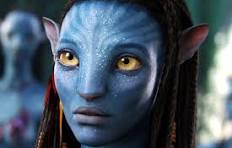

In [249]:
# Get hybrid recommendations for user 1 and movie 'Avatar'
hybrid(1, 'Avatar')

,title,vote_count,vote_average,year,id,est
522,Terminator 2: Judgment Day,4274.0,7.7,1991,280,3.187698
999,The Terminator,4208.0,7.4,1984,218,3.180675
8357,Star Trek Into Darkness,4479.0,7.4,2013,54138,3.011423
962,Aliens,3282.0,7.7,1986,679,2.860510
8622,X-Men: Days of Future Past,6155.0,7.5,2014,127585,2.851531
2006,Fantastic Planet,140.0,7.6,1973,16306,2.825091
1613,Darby O'Gill and the Little People,35.0,6.7,1959,18887,2.788505
910,The Abyss,822.0,7.1,1989,2756,2.758628
3052,Sinbad and the Eye of the Tiger,39.0,6.3,1977,11940,2.702134
2124,Superman II,642.0,6.5,1980,8536,2.649715


In [250]:
hybrid(500, 'Avatar')

,title,vote_count,vote_average,year,id,est
999,The Terminator,4208.0,7.4,1984,218,3.412285
2006,Fantastic Planet,140.0,7.6,1973,16306,3.286125
1613,Darby O'Gill and the Little People,35.0,6.7,1959,18887,3.227127
1660,Return from Witch Mountain,38.0,5.6,1978,14822,3.165231
8622,X-Men: Days of Future Past,6155.0,7.5,2014,127585,3.116114
2124,Superman II,642.0,6.5,1980,8536,3.107567
8692,Jupiter Ascending,2816.0,5.2,2015,76757,3.095173
962,Aliens,3282.0,7.7,1986,679,3.040015
4001,Hawk the Slayer,13.0,4.5,1980,25628,3.009084
522,Terminator 2: Judgment Day,4274.0,7.7,1991,280,2.983859


We see that for our hybrid recommender, we get different recommendations for different users although the movie is the same. Hence, our recommendations are more personalized and tailored towards particular users.

## Conclusion

In this notebook, I have built four different recommendation engines based on various ideas and algorithms. They are as follows:

1. **Simple Recommender**: This system utilized overall TMDB vote count and vote averages to build Top Movies charts, both general and genre-specific. The IMDb Weighted Rating system was used to calculate ratings, which were then used for sorting.

2. **Content-Based Recommender**: I developed two content-based engines—one using movie overviews and taglines, and another using metadata such as cast, crew, genre, and keywords. Additionally, I implemented a filter to prioritize movies with more votes and higher ratings.

3. **Collaborative Filtering**: Using the powerful Surprise library, I built a collaborative filtering engine based on Singular Value Decomposition (SVD). With an RMSE of less than 1, this engine predicted ratings for a given user and movie.

4. **Hybrid Engine**: I combined content-based and collaborative filtering techniques to create a hybrid engine that provided personalized movie recommendations based on the estimated ratings calculated for a particular user.
